# MBA Admission

## About Dataset

## 1. Data Source
- Synthetic data generated from the Wharton Class of 2025's statistics.

## 2. Meta Data

- **application_id**: Unique identifier for each application.
- **gender**: Applicant's gender (`Male`, `Female`).
- **international**: International student status (`TRUE`/`FALSE`).
- **gpa**: Grade Point Average of the applicant (on a 4.0 scale).
- **major**: Undergraduate major (`Business`, `STEM`, `Humanities`).
- **race**: Racial background of the applicant (e.g., `White`, `Black`, `Asian`, `Hispanic`, `Other` / `null`: international student).
- **gmat**: GMAT score of the applicant (maximum of 800 points).
- **work_exp**: Number of years of work experience (in years).
- **work_industry**: Industry of the applicant's previous work experience (e.g., `Consulting`, `Finance`, `Technology`, etc.).
- **admission**: Admission status (`Admit`, `Waitlist`, `Null`: Deny).

## 3. Usage

- **Classification**: Predict the admission status based on other features.


In [506]:
# Importing important Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#  for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc

# model
from sklearn import tree

# Loading & Reading Data

In [507]:
df = pd.read_csv('MBA.csv')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [508]:
df.info

<bound method DataFrame.info of       application_id  gender  international   gpa       major      race  \
0                  1  Female          False  3.30    Business     Asian   
1                  2    Male          False  3.28  Humanities     Black   
2                  3  Female           True  3.30    Business       NaN   
3                  4    Male          False  3.47        STEM     Black   
4                  5    Male          False  3.35        STEM  Hispanic   
...              ...     ...            ...   ...         ...       ...   
6189            6190    Male          False  3.49    Business     White   
6190            6191    Male          False  3.18        STEM     Black   
6191            6192  Female           True  3.22    Business       NaN   
6192            6193    Male           True  3.36    Business       NaN   
6193            6194    Male          False  3.23        STEM  Hispanic   

       gmat  work_exp          work_industry admission  
0     620.

In [509]:
df.shape

(6194, 10)

In [510]:
df.describe()

,application_id,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000,6194.000000
mean,3097.500000,3.250714,651.092993,5.016952
std,1788.198115,0.151541,49.294883,1.032432
min,1.000000,2.650000,570.000000,1.000000
25%,1549.250000,3.150000,610.000000,4.000000
50%,3097.500000,3.250000,650.000000,5.000000
75%,4645.750000,3.350000,680.000000,6.000000
max,6194.000000,3.770000,780.000000,9.000000


# Data Cleaning and Exploration

In [511]:
# We can drop column "application_id", as being a unique identifier, it won't be providing us useful information!
df = df.drop('application_id', axis=1)

In [512]:
df.shape

(6194, 9)

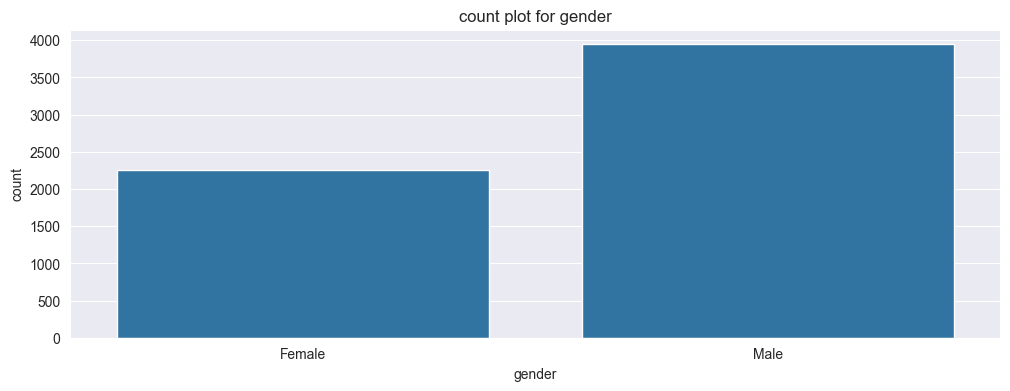

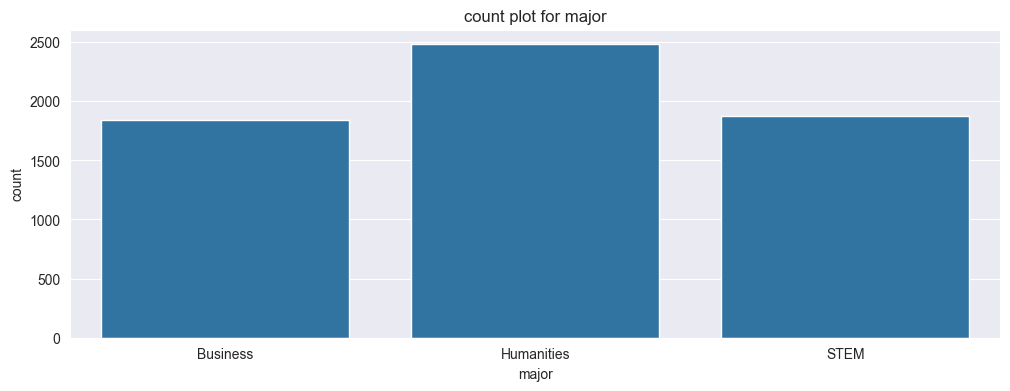

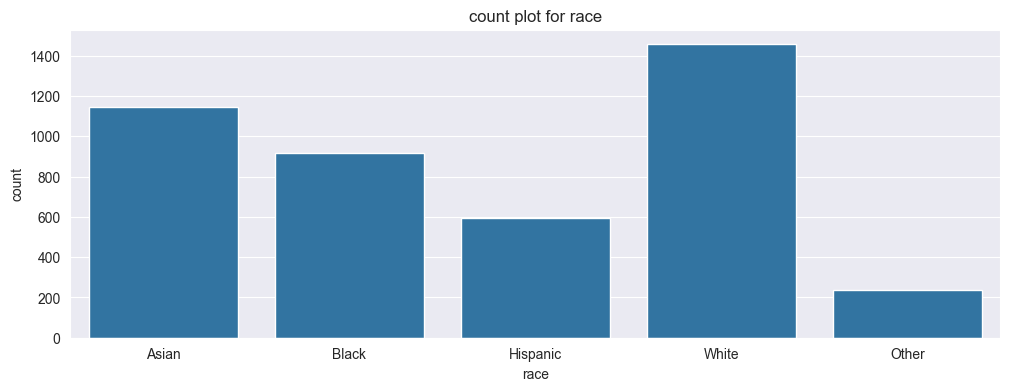

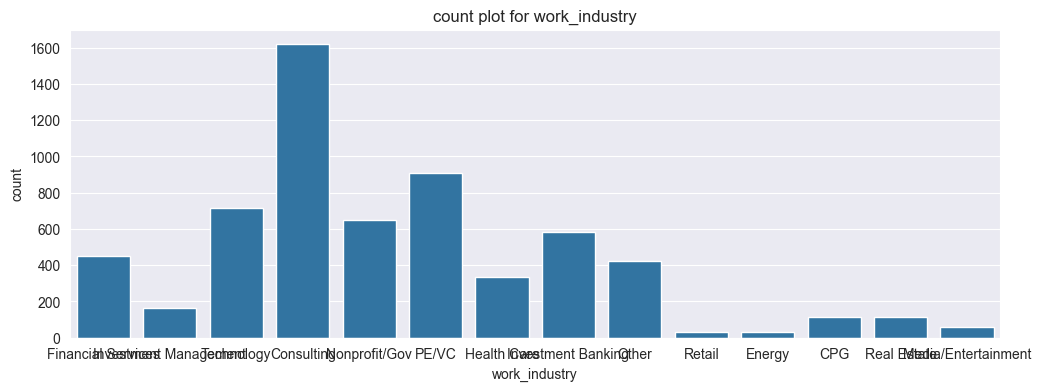

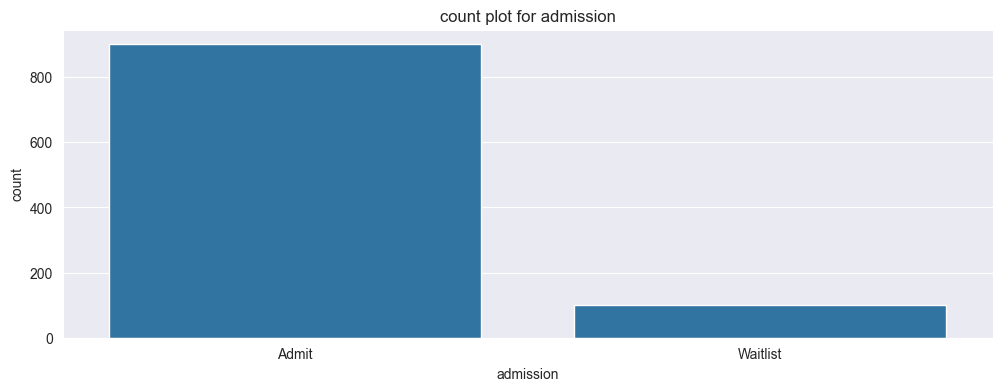

In [513]:
#just visualising all the columns in dataset
for cols in df.select_dtypes('object').columns :
    plt.figure(figsize=(12,4))
    sns.countplot(data=df, x=cols )
    plt.title(f"count plot for {cols}")
    plt.show()

In [514]:
#checking for missing Values
df.isna().sum()

gender              0
international       0
gpa                 0
major               0
race             1842
gmat                0
work_exp            0
work_industry       0
admission        5194
dtype: int64

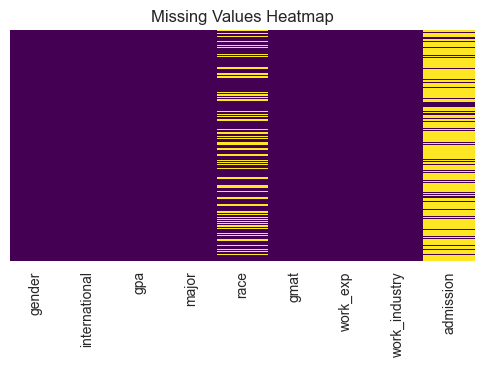

In [515]:
#plotting Heatmap for missing values
plt.figure(figsize=(6, 3))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

It is evident that there are numerous missing values in columns like "Race" (1,842 missing values) and "Admission" (5,194 missing values). The missing values in the "Admission" column likely represent students who were not admitted, which makes sense in this context. However, for the "Race" column, it’s possible that the missing entries are from international students who may have left this question unanswered. Let's examine this in more detail.

In [516]:
total_missing_race = df['race'].isna().sum()

# 2. Count missing `race` values where `international` is TRUE
missing_race_international_true = df[df['race'].isna() & (df['international'] == True)].shape[0]

# 3. Count missing `race` values where `international` is FALSE
missing_race_international_false = df[df['race'].isna() & (df['international'] == False)].shape[0]

# 4. Calculate proportions
proportion_international_true = missing_race_international_true / total_missing_race
proportion_international_false = missing_race_international_false / total_missing_race

print("Total missing `race` values:", total_missing_race)
print("Missing `race` values where `international` is TRUE:", missing_race_international_true)
print("Missing `race` values where `international` is FALSE:", missing_race_international_false)
print("Proportion of missing `race` for international students (TRUE):", proportion_international_true)
print("Proportion of missing `race` for domestic students (FALSE):", proportion_international_false)

Total missing `race` values: 1842
Missing `race` values where `international` is TRUE: 1842
Missing `race` values where `international` is FALSE: 0
Proportion of missing `race` for international students (TRUE): 1.0
Proportion of missing `race` for domestic students (FALSE): 0.0


###  Missing Values analysis

As we suspected earlier, it is now clear that only international students left this question unanswered. 

Since these missing values are of the *"MAR"* (Missing at Random) type and cannot be ignored, we can impute them with terms like **"Other"** or **"Unknown"**, but we cannot simply drop them.



For the missing values in the *"Admission"* column, we can impute them with the term **"Not Admitted,"** which serves as the logical counterpart to **"Admitted."**


# Feature Engineering

In [517]:
# imputing 'others' into column 'race'
df["race"] = df["race"].fillna('others')
print(df["race"].unique())
print(df["race"].isna().sum())

['Asian' 'Black' 'others' 'Hispanic' 'White' 'Other']
0


In [518]:
# imputing 'not admitted' into col "admission"
df['admission'] = df['admission'].fillna('Not admitted')
print(df['admission'].unique())
print(df['admission'].isna().sum())

['Admit' 'Not admitted' 'Waitlist']
0


In [519]:
#just for simplicity, we are going to add another column from called admission_binary, which will have only two possibilities either got admitted or not. In which, students with waitlist will be replacing with not admit. 

df['admission_binary'] = df['admission'].apply(lambda x: 'Not admitted' if x == 'Waitlist' else x)
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission,admission_binary
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Not admitted,Not admitted
2,Female,True,3.30,Business,others,710.0,5.0,Technology,Admit,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Not admitted,Not admitted
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Not admitted,Not admitted


# Developing and Training Model

In [520]:
# preparing the data for modelling
X = df.drop(['admission','admission_binary'], axis =1)
y = df['admission']

In [521]:
# this will encode the categorical data
le=LabelEncoder()
for cols in X.select_dtypes('object').columns:
    X[cols]=le.fit_transform(X[cols])

In [522]:
y=le.fit_transform(y)

In [523]:
# splitting the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [524]:
# defining and adjusting the Model
model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

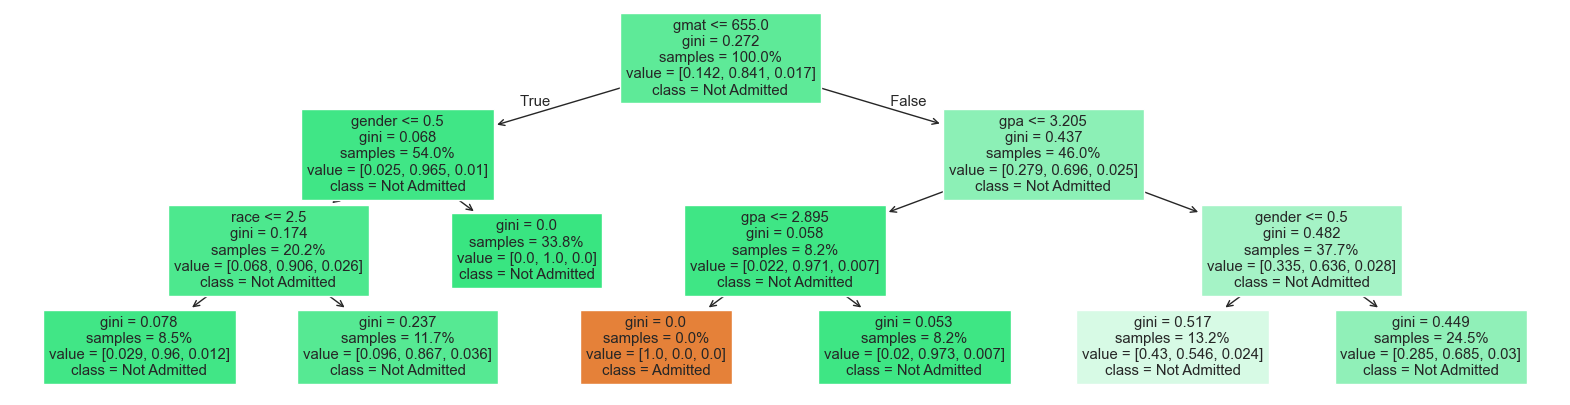

In [525]:
# Visualizing the Decision Tree for 3 outcomes
plt.figure(figsize=(20, 5))
tree.plot_tree(
    model, 
    filled=True, 
    feature_names=list(X_train.columns), 
    class_names=['Admitted', 'Not Admitted', 'Waiting List'], 
    proportion=True
)
plt.show()

# Evaluation and Validation

In [526]:
# making predictions for the testset
y_pred = model.predict(X_test)

In [527]:
# calculating the confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[   0,  196,    0],
       [   0, 1025,    0],
       [   0,   18,    0]])

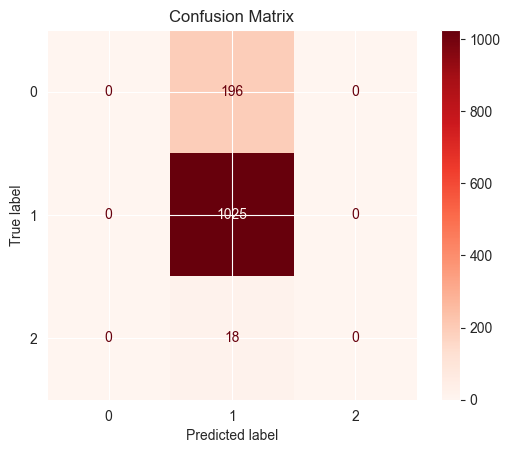

In [528]:
#  displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

In [529]:
# Calculate accuracy, precision, recall, and F1 score with an appropriate averaging method
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)   # Used 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Printing  metrics
print(f"Accuracy on the test set: {accuracy:.2f}")
print(f"Precision on the test set: {precision:.2f}")
print(f"Recall on the test set: {recall:.2f}")
print(f"F1 Score on the test set: {f1:.2f}")

Accuracy on the test set: 0.83
Precision on the test set: 0.68
Recall on the test set: 0.83
F1 Score on the test set: 0.75


### Model Performance Metrics

- **Accuracy (83%)**: 
    - Overall, the model correctly classifies 83% of test samples. This is a good indication of performance but doesn’t give insights into individual class performance.

- **Precision (68%)**: 
    - When the model predicts a positive class, it’s correct 68% of the time. This relatively lower precision suggests that some incorrect positive predictions (false positives) were made.

- **Recall (83%)**: 
    - Of the actual positive cases, the model successfully identifies 83%. This high recall shows the model is effective at identifying most true positives, though it may include some false positives.

- **F1 Score (75%)**: 
    - This balance of precision and recall suggests the model maintains a reasonable trade-off between catching true positives and avoiding false positives, with an overall harmonic mean of 75%.


In [530]:
# Calculate the metrics for each class
report = classification_report(y_test, y_pred, target_names=['Not Admitted', 'Admitted', 'Waiting List'], zero_division=0)
print(report)

              precision    recall  f1-score   support

Not Admitted       0.00      0.00      0.00       196
    Admitted       0.83      1.00      0.91      1025
Waiting List       0.00      0.00      0.00        18

    accuracy                           0.83      1239
   macro avg       0.28      0.33      0.30      1239
weighted avg       0.68      0.83      0.75      1239



### Model Performance Summary

### Overall Performance:
- The model achieves **83% accuracy**, indicating it correctly predicts most instances, but this is largely driven by the dominant **"Admitted"** class.

### Class Performance:

- **"Admitted" Class**: 
  - The model performs well with **83% precision**, **100% recall**, and **91% F1 score**, correctly identifying almost all **"Admitted"** instances.
  
- **"Not Admitted" and "Waiting List" Classes**: 
  - The model fails to predict these classes, with **0% precision**, **0% recall**, and **0% F1 score** for both, suggesting issues in handling these minority classes.

### Averages:

- **Macro Average**: 
  - **Precision**: 0.28
  - **Recall**: 0.33
  - **F1 score**: 0.30
  - These are low, indicating the model struggles to handle all classes equally well.

- **Weighted Average**: 
  - **Precision**: 0.68
  - **Recall**: 0.83
  - **F1 score**: 0.75
  - These are higher, reflecting the strong performance on the **"Admitted"** class, but still showing the imbalance in handling the minority classes.


### Potential Solutions:

- **Resampling Techniques**: 
  - You might consider using oversampling (e.g., SMOTE) or undersampling to balance the dataset.

- **Class Weights**: 
  - Adjusting class weights in the model (giving more importance to the minority classes) could help the model pay more attention to **"Not Admitted"** and **"Waiting List"**.

- **Further Tuning**: 
  - Hyperparameter tuning or exploring different models may improve performance on the minority classes.

### Decision:
The first two solutions are out of scope, and we are bound with Model: **Decision Tree** for this problem, so we'll go with **Simple Tuning**!


# Tuning

In [531]:
# Assuming you have the data in X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Tuning: Adjust class weights to handle imbalanced classes
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# 2. Tuning: Pruning the tree by limiting max depth and minimum samples to split
model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Admitted', 'Admitted', 'Waiting List'], zero_division=0))


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, F1 Score for each class
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

Not Admitted       0.42      0.41      0.42       299
    Admitted       0.98      0.60      0.75      1525
Waiting List       0.03      0.63      0.07        35

    accuracy                           0.57      1859
   macro avg       0.48      0.55      0.41      1859
weighted avg       0.87      0.57      0.68      1859

Accuracy: 0.57
Precision: 0.87
Recall: 0.57
F1 Score: 0.68


## Summary:

### Strengths:
- Your model performs well for the **Admitted** class with a high **precision** and reasonable **recall**.

### Weaknesses:
- The **Waiting List** and **Not Admitted** classes still have very poor performance in terms of **precision**, **recall**, and **F1-score**, indicating that the model struggles to predict these classes accurately.
- **Accuracy** remains low at **57%**, suggesting that the model is overall biased towards the majority class (**Admitted**).
